In [1]:
from __future__ import print_function, division
#add project directory to python path
import sys
sys.path.append("..")
from defaults import PROJECT_DIRECTORY, DATA_DIRECTORY
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# Load catalogs

In [24]:
from pandas import read_csv

#set location of data files
deep_file = DATA_DIRECTORY + 'hsc_data.csv'
rand_file = DATA_DIRECTORY + 'hsc_randoms.csv'

#get column info
from data.hsc_data_types import cols as data_cols
from data.hsc_randoms_types import cols as ran_cols

#read in column info for the data file
data_dtypes = get_ordered_list(data_cols)
data_names = [x for x,y in data_dtypes]

#read in column info for the randoms file
ran_dtypes =  get_ordered_list(ran_cols)
ran_names = [x for x,y in ran_dtypes]

In [25]:
#load data file
hsc_data = read_csv(deep_file, dtype=data_dtypes, engine='c', header=0, names=data_names) #note that there are some missing values and mixed types

In [27]:
#load random file
hsc_randoms = read_csv(rand_file, dtype=ran_dtypes, engine='c', header=0, names=ran_names)

In [28]:
#check the number of galaxies
print("number of galaxies: ", len(hsc_data))
print("number of randoms: ", len(hsc_randoms))

number of galaxies:  10294602
number of randoms:  10564959


In [29]:
def get_ordered_list(data_cols):
    """
    return an ordered list from column dtypes dict
    """
    names = np.array(data_cols.keys())
    order = np.zeros(len(names)).astype('int')
    column_types = []
    for i in range(0,len(names)):
        order[i] = data_cols[names[i]][0]
        column_types.append(data_cols[names[i]][1])
    sort_inds = np.argsort(order)
    column_types = np.array(column_types)
    names = names[sort_inds]
    order = order[sort_inds]
    column_types = column_types[sort_inds]
    data_dtypes = [(x,np.dtype(y).type) for x, y in zip(names, column_types)]
    return data_dtypes

# make cuts on data

In [30]:
#make some further cuts on the data
bright_mask = (hsc_data['iflags_pixel_bright_object_center']==False)
ran_bright_bmask = (hsc_randoms['iflags_pixel_bright_object_center']==False)
nan_mask = (np.isnan(hsc_data['imag_forced_cmodel'])==False)
inf_mask = (np.isinf(hsc_data['imag_forced_cmodel'])==False)

#invert masks
data_mask = (bright_mask & nan_mask & inf_mask)
randoms_mask = (ran_bright_bmask)

#remove masked galaxies and randoms
hsc_data = hsc_data[data_mask]
hsc_randoms = hsc_randoms[randoms_mask]

#check number of galaxies in sample
print("number of galaxies: ", len(hsc_data))
print("number of randoms: ", len(hsc_randoms))

number of galaxies:  9172467
number of randoms:  9385922


# define and plot fields

In [31]:
#define fields
Nfields=4
field_bounding_boxes = [[34,38,-6.5,-3], #min_ra, max_ra, min_dec, max_dec
                        [148,152,0,4],
                        [240,246,53,57],
                        [350,354,-2,1.5]]

#define some masks for each field

#convert to record arrays
fdata = hsc_data.to_records()
frdata = hsc_randoms.to_records()

data_field_mask_1 = (fdata['ira'] > field_bounding_boxes[0][0]) &\
                    (fdata['ira'] < field_bounding_boxes[0][1]) &\
                    (fdata['idec'] > field_bounding_boxes[0][2]) &\
                    (fdata['idec'] < field_bounding_boxes[0][3]) 
data_field_mask_2 = (fdata['ira'] > field_bounding_boxes[1][0]) &\
                    (fdata['ira'] < field_bounding_boxes[1][1]) &\
                    (fdata['idec'] > field_bounding_boxes[1][2]) &\
                    (fdata['idec'] < field_bounding_boxes[1][3]) 
data_field_mask_3 = (fdata['ira'] > field_bounding_boxes[2][0]) &\
                    (fdata['ira'] < field_bounding_boxes[2][1]) &\
                    (fdata['idec'] > field_bounding_boxes[2][2]) &\
                    (fdata['idec'] < field_bounding_boxes[2][3]) 
data_field_mask_4 = (fdata['ira'] > field_bounding_boxes[3][0]) &\
                    (fdata['ira'] < field_bounding_boxes[3][1]) &\
                    (fdata['idec'] > field_bounding_boxes[3][2]) &\
                    (fdata['idec'] < field_bounding_boxes[3][3]) 

ran_field_mask_1 = (frdata['ra'] > field_bounding_boxes[0][0]) &\
                    (frdata['ra'] < field_bounding_boxes[0][1]) &\
                    (frdata['dec'] > field_bounding_boxes[0][2]) &\
                    (frdata['dec'] < field_bounding_boxes[0][3]) 
ran_field_mask_2 = (frdata['ra'] > field_bounding_boxes[1][0]) &\
                    (frdata['ra'] < field_bounding_boxes[1][1]) &\
                    (frdata['dec'] > field_bounding_boxes[1][2]) &\
                    (frdata['dec'] < field_bounding_boxes[1][3]) 
ran_field_mask_3 = (frdata['ra'] > field_bounding_boxes[2][0]) &\
                    (frdata['ra'] < field_bounding_boxes[2][1]) &\
                    (frdata['dec'] > field_bounding_boxes[2][2]) &\
                    (frdata['dec'] < field_bounding_boxes[2][3]) 
ran_field_mask_4 = (frdata['ra'] > field_bounding_boxes[3][0]) &\
                    (frdata['ra'] < field_bounding_boxes[3][1]) &\
                    (frdata['dec'] > field_bounding_boxes[3][2]) &\
                    (frdata['dec'] < field_bounding_boxes[3][3]) 

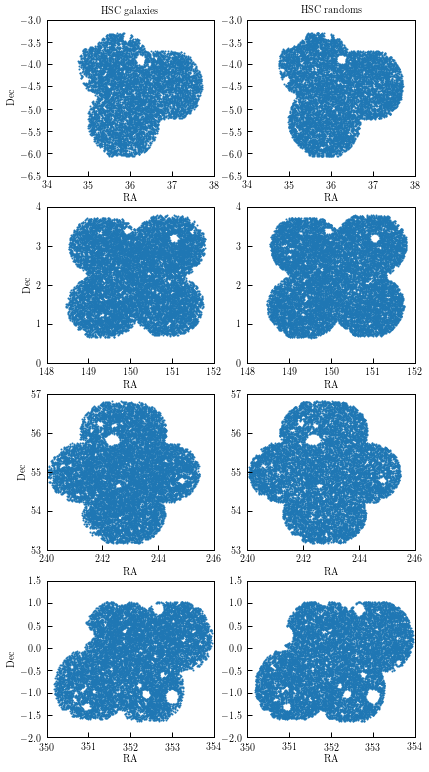

In [35]:
#plot the spatial distribution of galaxies and randoms in fields as a sanity check

#subsample to make plotting easier
subsamp = np.random.choice(len(fdata), 50000)
rsubsamp = np.random.choice(len(frdata), 50000)

subsamp = np.in1d(np.arange(0,len(fdata)),subsamp)
rsubsamp = np.in1d(np.arange(0,len(frdata)),rsubsamp)

#plot each field
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(3.3*2,3.3*4))
for i in range(0,Nfields):
    ax1,ax2 = (axes[i,0], axes[i,1])
    if i==0:
        ax1.set_title('HSC galaxies')
        ax2.set_title('HSC randoms')
    min_ra = field_bounding_boxes[i][0]
    max_ra = field_bounding_boxes[i][1]
    min_dec = field_bounding_boxes[i][2]
    max_dec = field_bounding_boxes[i][3]
    ax1.scatter(fdata['ira'][subsamp], fdata['idec'][subsamp], s=1)
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Dec')
    ax1.set_xlim([min_ra, max_ra])
    ax1.set_ylim([min_dec, max_dec])
    ax2.scatter(frdata['ra'][rsubsamp], frdata['dec'][rsubsamp], s=1)
    ax2.set_xlabel('RA')
    ax2.set_xlim([min_ra, max_ra])
    ax2.set_ylim([min_dec, max_dec])
plt.show()

# Caclulate area of survey

In [86]:
# Calculate the effective area of the survey
# There are 100 random points per square arcmin.

area_sq_arcmin = float(len(hsc_randoms))/100.0
area_sq_deg = area_sq_arcmin/3600.0

print('Total area in square arcmin, square degrees: ', area_sq_arcmin, area_sq_deg)

#calculate area of individual fields

full_area_sq_arcmin = float(len(hsc_randoms[ran_field_mask_1]))/100.0
full_area_sq_deg = full_area_sq_arcmin/3600.0
print('Area of deep field 1 in square arcmin: ', full_area_sq_arcmin, full_area_sq_deg)
area_sq_arcmin = float(len(hsc_randoms[ran_field_mask_2]))/100.0
area_sq_deg = area_sq_arcmin/3600.0
print('Area of deep field 2 in square arcmin: ', area_sq_arcmin, area_sq_deg)
area_sq_arcmin = float(len(hsc_randoms[ran_field_mask_3]))/100.0
area_sq_deg = area_sq_arcmin/3600.0
print('Area of deep field 3 in square arcmin: ', area_sq_arcmin, area_sq_deg)
area_sq_arcmin = float(len(hsc_randoms[ran_field_mask_4]))/100.0
area_sq_deg = area_sq_arcmin/3600.0
print('Area of deep field 4 in square arcmin: ', area_sq_arcmin, area_sq_deg)

Total area in square arcmin, square degrees:  93859.22 26.0720055556
Area of deep field 1 in square arcmin:  18314.15 5.08726388889
Area of deep field 2 in square arcmin:  28104.28 7.80674444444
Area of deep field 3 in square arcmin:  23422.92 6.50636666667
Area of deep field 4 in square arcmin:  24017.87 6.67163055556


# calculate apparent magnitude functions

In [110]:
#calculate cumulative apparent magnitude function
g_mag = hsc_data['gmag_forced_cmodel'] - hsc_data['a_g'] #correct for dust
g_mag = np.sort(g_mag)
N_g = np.cumsum(np.ones(len(g_mag)))
n_g = N_g/full_area_sq_deg #cumulative number density

r_mag = hsc_data['rmag_forced_cmodel'] - hsc_data['a_r'] #correct for dust
r_mag = np.sort(r_mag)
N_r = np.cumsum(np.ones(len(r_mag)))
n_r = N_r/full_area_sq_deg #cumulative number density

i_mag = hsc_data['imag_forced_cmodel'] - hsc_data['a_i'] #correct for dust
i_mag = np.sort(i_mag)
N_i = np.cumsum(np.ones(len(i_mag)))
n_i = N_i/full_area_sq_deg #cumulative number density

z_mag = hsc_data['zmag_forced_cmodel'] - hsc_data['a_z'] #correct for dust
z_mag = np.sort(z_mag)
N_z = np.cumsum(np.ones(len(z_mag)))
n_z = N_z/full_area_sq_deg #cumulative number density

y_mag = hsc_data['ymag_forced_cmodel'] - hsc_data['a_y'] #correct for dust
y_mag = np.sort(y_mag)
N_y = np.cumsum(np.ones(len(y_mag)))
n_y = N_y/full_area_sq_deg #cumulative number density

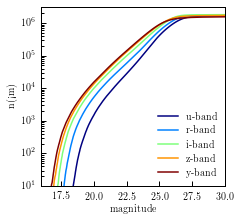

In [111]:
#plot cumulative mag functions
colors = pl.cm.jet(np.linspace(0,1,5))  
plt.figure(figsize=(3.3,3.3))
l1, = plt.plot(g_mag, n_g, '-', color=colors[0])
l2, = plt.plot(r_mag, n_r, '-', color=colors[1])
l3, = plt.plot(i_mag, n_i, '-', color=colors[2])
l4, = plt.plot(z_mag, n_z, '-', color=colors[3])
l5, = plt.plot(y_mag, n_y, '-', color=colors[4])
plt.yscale('log')
plt.xlim([16,30])
plt.ylim([10,10**6.5])
plt.xlabel('magnitude')
plt.ylabel('n(<m)')
plt.legend([l1, l2, l3, l4, l5],['u-band','r-band','i-band','z-band','y-band'],
           frameon=False, fontsize=10, loc='lower right')
plt.show()

# fit power law to faint end

In [112]:
#calculate number density at at fixed points

m_bins = np.arange(17.0,30.0,0.2)

inds = np.searchsorted(g_mag, m_bins)
n_sample_g = n_g[inds]

inds = np.searchsorted(r_mag, m_bins)
n_sample_r = n_r[inds]

inds = np.searchsorted(i_mag, m_bins)
n_sample_i = n_i[inds]

inds = np.searchsorted(z_mag, m_bins)
n_sample_z = n_z[inds]

inds = np.searchsorted(y_mag, m_bins)
n_sample_y = n_y[inds]

In [113]:
#fit power law to faint end slope

#define power-law model
def power_law(m, A=0.39, B=5.0, n0=0.01):
    return n0*(10.0**(A*(m-B)))

#fit power law to data points
from scipy.optimize import curve_fit

#define range over which to fit power law for each band
g_mask = (m_bins>23) & (m_bins<25)
popt_g, pcov_g = curve_fit(power_law, m_bins[g_mask], n_sample_g[g_mask])
r_mask = (m_bins>23) & (m_bins<25)
popt_r, pcov_r = curve_fit(power_law, m_bins[r_mask], n_sample_r[r_mask])
i_mask = (m_bins>23) & (m_bins<25)
popt_i, pcov_i = curve_fit(power_law, m_bins[i_mask], n_sample_i[i_mask])
z_mask = (m_bins>23) & (m_bins<25)
popt_z, pcov_z = curve_fit(power_law, m_bins[z_mask], n_sample_z[z_mask])
y_mask = (m_bins>23) & (m_bins<25)
popt_y, pcov_y = curve_fit(power_law, m_bins[y_mask], n_sample_y[y_mask])

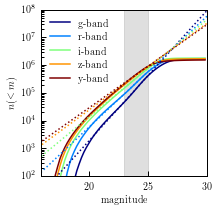

In [114]:
#plot power law fits
m_sample = np.linspace(15,30,100)

colors = pl.cm.jet(np.linspace(0,1,5))  
fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

plt.fill_between([23,25],[0.1,0.1],[10**9,10**9],color='grey', alpha=0.25)

#data
p1, = plt.plot(m_bins, n_sample_g, '-', color=colors[0])
p2, = plt.plot(m_bins, n_sample_r, '-', color=colors[1])
p3, = plt.plot(m_bins, n_sample_i, '-', color=colors[2])
p4, = plt.plot(m_bins, n_sample_z, '-', color=colors[3])
p5, = plt.plot(m_bins, n_sample_y, '-', color=colors[4])
#fits
plt.plot(m_sample, power_law(m_sample, *popt_g),':', color=colors[0])
plt.plot(m_sample, power_law(m_sample, *popt_r),':', color=colors[1])
plt.plot(m_sample, power_law(m_sample, *popt_i),':', color=colors[2])
plt.plot(m_sample, power_law(m_sample, *popt_z),':', color=colors[3])
plt.plot(m_sample, power_law(m_sample, *popt_y),':', color=colors[4])

plt.yscale('log')
plt.xlim([16,30])
plt.ylim([10**2,10**8])
plt.xlabel('magnitude')
plt.ylabel(r'$n(<m)$')
plt.legend([p1, p2, p3, p4, p5],['g-band','r-band','i-band','z-band','y-band'], frameon=False,
           fontsize=10, numpoints=1, loc='upper left')
plt.show()

fig.savefig('/Users/duncan/Desktop/hsc_app_mag_func.pdf',dpi=250)

# Define jackknife samples

In [70]:
#find ra and dec values that split fields into 4 equal parts

class quad_split(object):
    """
    splits a plane into 4 equal number quadrants
    """
    def __init__(self,ra,dec,max_iter=100):    
        
        self.ra = ra
        self.dec = dec
        
        self.min_ra = np.min(ra)
        self.max_ra = np.max(ra)
        
        self.min_dec = np.min(dec)
        self.max_dec = np.max(dec)
        
        self.max_iter=max_iter
        
        self.find_ra_boundary()
        self.find_dec_boundary()
        
    def find_ra_boundary(self):
        
        self.ra_split = (self.min_ra+self.max_ra)/2.0
        da = (self.max_ra-self.min_ra)/2.0
        
        df = 0.5
        f0 = 0.5
        
        i=0
        while df>0.01:
            i+=1
            N_above = 1.0*np.sum(self.ra > self.ra_split)
            N_below = 1.0*np.sum(self.ra <= self.ra_split)
            
            if N_above>N_below:
                self.ra_split = self.ra_split+da
                da = da/2.0
            elif  N_above<N_below:
                self.ra_split = self.ra_split-da
                da = da/2.0
            else:
                break
            
            if i>self.max_iter:
                break
            
        self.ra_iter=i     
    
    def find_dec_boundary(self):
        
        self.dec_split = (self.min_dec+self.max_dec)/2.0
        da = (self.max_dec-self.min_dec)/2.0
        
        df = 0.5
        f0 = 0.5
        i=0
        while df>0.01:
            i+=1
            N_above = 1.0*np.sum(self.dec > self.dec_split)
            N_below = 1.0*np.sum(self.dec <= self.dec_split)
            
            if N_above>N_below:
                self.dec_split = self.dec_split+da
                da = da/2.0
            elif  N_above<N_below:
                self.dec_split = self.dec_split-da
                da = da/2.0
            else:
                break
            
            if i>self.max_iter:
                break
            
        self.dec_iter=i  

In [71]:
#use randoms to split each field into 4 equal area sub-samples
s1 = quad_split(frdata['ra'][ran_field_mask_1], frdata['dec'][ran_field_mask_1])
s2 = quad_split(frdata['ra'][ran_field_mask_2], frdata['dec'][ran_field_mask_2])
s3 = quad_split(frdata['ra'][ran_field_mask_3], frdata['dec'][ran_field_mask_3])
s4 = quad_split(frdata['ra'][ran_field_mask_4], frdata['dec'][ran_field_mask_4])

In [72]:
#store the results
ra_splits = [s1.ra_split,s2.ra_split,s3.ra_split,s4.ra_split]
dec_splits = [s1.dec_split,s2.dec_split,s3.dec_split,s4.dec_split]

In [73]:
#define masks for each data jackknife sample
mask_11 = (fdata['ira']<s1.ra_split) &\
         (fdata['idec']<=s1.dec_split)&\
          data_field_mask_1

mask_12 = (fdata['ira']>s1.ra_split) &\
         (fdata['idec']>=s1.dec_split)&\
          data_field_mask_1

mask_13 = (fdata['ira']<=s1.ra_split) &\
         (fdata['idec']>s1.dec_split)&\
          data_field_mask_1

mask_14 = (fdata['ira']>=s1.ra_split) &\
         (fdata['idec']<s1.dec_split)&\
          data_field_mask_1

mask_21 = (fdata['ira']<s2.ra_split) &\
         (fdata['idec']<=s2.dec_split)&\
          data_field_mask_2

mask_22 = (fdata['ira']>s2.ra_split) &\
         (fdata['idec']>=s2.dec_split)&\
          data_field_mask_2

mask_23 = (fdata['ira']<=s2.ra_split) &\
         (fdata['idec']>s2.dec_split)&\
          data_field_mask_2

mask_24 = (fdata['ira']>=s2.ra_split) &\
         (fdata['idec']<s2.dec_split)&\
          data_field_mask_2

mask_31 = (fdata['ira']<s3.ra_split) &\
         (fdata['idec']<=s3.dec_split)&\
          data_field_mask_3

mask_32 = (fdata['ira']>s3.ra_split) &\
         (fdata['idec']>=s3.dec_split)&\
          data_field_mask_3

mask_33 = (fdata['ira']<=s3.ra_split) &\
         (fdata['idec']>s3.dec_split)&\
          data_field_mask_3

mask_34 = (fdata['ira']>=s3.ra_split) &\
         (fdata['idec']<s3.dec_split)&\
          data_field_mask_3

mask_41 = (fdata['ira']<s4.ra_split) &\
         (fdata['idec']<=s4.dec_split)&\
          data_field_mask_4

mask_42 = (fdata['ira']>s4.ra_split) &\
         (fdata['idec']>=s4.dec_split)&\
          data_field_mask_4

mask_43 = (fdata['ira']<=s4.ra_split) &\
         (fdata['idec']>s4.dec_split)&\
          data_field_mask_4

mask_44 = (fdata['ira']>=s4.ra_split) &\
         (fdata['idec']<s4.dec_split)&\
          data_field_mask_4

j_masks = [mask_11, mask_12, mask_13, mask_14,
         mask_21, mask_22, mask_23, mask_24,
         mask_31, mask_32, mask_33, mask_34,
         mask_41, mask_42, mask_43, mask_44]

In [74]:
#define masks for each random jackknife sample

ran_mask_11 = (frdata['ra']<s1.ra_split) &\
         (frdata['dec']<=s1.dec_split)&\
          ran_field_mask_1

ran_mask_12 = (frdata['ra']>s1.ra_split) &\
         (frdata['dec']>=s1.dec_split)&\
          ran_field_mask_1

ran_mask_13 = (frdata['ra']<=s1.ra_split) &\
         (frdata['dec']>s1.dec_split)&\
          ran_field_mask_1

ran_mask_14 = (frdata['ra']>=s1.ra_split) &\
         (frdata['dec']<s1.dec_split)&\
          ran_field_mask_1

ran_mask_21 = (frdata['ra']<s2.ra_split) &\
         (frdata['dec']<=s2.dec_split)&\
          ran_field_mask_2

ran_mask_22 = (frdata['ra']>s2.ra_split) &\
         (frdata['dec']>=s2.dec_split)&\
          ran_field_mask_2

ran_mask_23 = (frdata['ra']<=s2.ra_split) &\
         (frdata['dec']>s2.dec_split)&\
          ran_field_mask_2

ran_mask_24 = (frdata['ra']>=s2.ra_split) &\
         (frdata['dec']<s2.dec_split)&\
          ran_field_mask_2

ran_mask_31 = (frdata['ra']<s3.ra_split) &\
         (frdata['dec']<=s3.dec_split)&\
          ran_field_mask_3

ran_mask_32 = (frdata['ra']>s3.ra_split) &\
         (frdata['dec']>=s3.dec_split)&\
          ran_field_mask_3

ran_mask_33 = (frdata['ra']<=s3.ra_split) &\
         (frdata['dec']>s3.dec_split)&\
          ran_field_mask_3

ran_mask_34 = (frdata['ra']>=s3.ra_split) &\
         (frdata['dec']<s3.dec_split)&\
          ran_field_mask_3

ran_mask_41 = (frdata['ra']<s4.ra_split) &\
         (frdata['dec']<=s4.dec_split)&\
          ran_field_mask_4

ran_mask_42 = (frdata['ra']>s4.ra_split) &\
         (frdata['dec']>=s4.dec_split)&\
          ran_field_mask_4

ran_mask_43 = (frdata['ra']<=s4.ra_split) &\
         (frdata['dec']>s4.dec_split)&\
          ran_field_mask_4

ran_mask_44 = (frdata['ra']>=s4.ra_split) &\
         (frdata['dec']<s4.dec_split)&\
          ran_field_mask_4

j_ran_masks = [ran_mask_11, ran_mask_12, ran_mask_13, ran_mask_14,
         ran_mask_21, ran_mask_22, ran_mask_23, ran_mask_24,
         ran_mask_31, ran_mask_32, ran_mask_33, ran_mask_34,
         ran_mask_41, ran_mask_42, ran_mask_43, ran_mask_44]

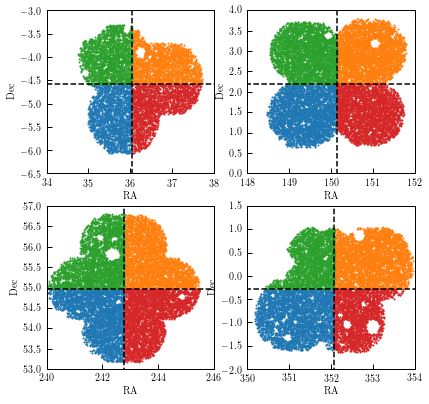

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.3*2,3.3*2))
axes= axes.flatten()

for i in range(0,Nfields):
    ax1 = axes[i]
    min_ra = field_bounding_boxes[i][0]
    max_ra = field_bounding_boxes[i][1]
    min_dec = field_bounding_boxes[i][2]
    max_dec = field_bounding_boxes[i][3]
    for j in range(0,4):
        mask = j_masks[i*4+j]
        ax1.scatter(fdata['ira'][subsamp & mask], fdata['idec'][subsamp & mask], s=1)
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Dec')
    ax1.set_xlim([min_ra, max_ra])
    ax1.set_ylim([min_dec, max_dec])
    #plot boundaries
    ax1.plot([ra_splits[i],ra_splits[i]],[-90,90], '--', color='black')
    ax1.plot([0,360],[dec_splits[i],dec_splits[i]], '--', color='black')
plt.show()

# calculate jackknife errors on magnitude functions

In [180]:
Nr = len(hsc_randoms)
Nj = len(j_masks)
m_bins = np.arange(12,30,0.1)

#create arrays to store jackknife calcs
n_sample_gs = np.zeros((Nj,180))
n_sample_rs = np.zeros((Nj,180))
n_sample_is = np.zeros((Nj,180))
n_sample_zs = np.zeros((Nj,180))
n_sample_ys = np.zeros((Nj,180))

popt_gs = np.zeros((Nj,3))
popt_rs = np.zeros((Nj,3))
popt_is = np.zeros((Nj,3))
popt_zs = np.zeros((Nj,3))
popt_ys = np.zeros((Nj,3))

#loop through samples
for i in range(0,len(j_masks)):
    
    #remove only the sub-field
    d_mask = ~j_masks[i]
    r_mask = ~j_ran_masks[i]
    
    N = np.sum(d_mask)
    print(i, N)
    
    #calculate the area of each jackknife sample
    Nsub = np.sum(r_mask)
    f = 1.0*Nsub/Nr 
    sub_area_sq_deg = f*full_area_sq_deg
    
    #calculate cumulative apparent magnitude function
    
    g_mag = hsc_data['gmag_forced_cmodel'][d_mask] - hsc_data['a_g'][d_mask] #correct for dust
    g_mag = np.sort(g_mag)
    N_g = np.cumsum(np.ones(len(g_mag)))
    n_g = N_g/(sub_area_sq_deg) #cumulative number density
    
    r_mag = hsc_data['rmag_forced_cmodel'][d_mask] - hsc_data['a_r'][d_mask] #correct for dust
    r_mag = np.sort(r_mag)
    N_r = np.cumsum(np.ones(len(r_mag)))
    n_r = N_r/(sub_area_sq_deg) #cumulative number density
    
    i_mag = hsc_data['imag_forced_cmodel'][d_mask] - hsc_data['a_i'][d_mask] #correct for dust
    i_mag = np.sort(i_mag)
    N_i = np.cumsum(np.ones(len(i_mag)))
    n_i = N_i/(sub_area_sq_deg) #cumulative number density
    
    z_mag = hsc_data['zmag_forced_cmodel'][d_mask] - hsc_data['a_z'][d_mask] #correct for dust
    z_mag = np.sort(z_mag)
    N_z = np.cumsum(np.ones(len(z_mag)))
    n_z = N_z/(sub_area_sq_deg) #cumulative number density

    y_mag = hsc_data['ymag_forced_cmodel'][d_mask] - hsc_data['a_r'][d_mask] #correct for dust
    y_mag = np.sort(y_mag)
    N_y = np.cumsum(np.ones(len(y_mag)))
    n_y = N_y/(sub_area_sq_deg) #cumulative number density

    inds = np.searchsorted(g_mag, m_bins)
    n_sample_g = n_g[inds]
    
    inds = np.searchsorted(r_mag, m_bins)
    n_sample_r = n_r[inds]
    
    inds = np.searchsorted(i_mag, m_bins)
    n_sample_i = n_i[inds]
    
    inds = np.searchsorted(z_mag, m_bins)
    n_sample_z = n_z[inds]

    inds = np.searchsorted(y_mag, m_bins)
    n_sample_y = n_y[inds]
    
    #define range over which to fit power law for each band
    g_mask = (m_bins>23) & (m_bins<25)
    popt_g, pcov_g = curve_fit(power_law, m_bins[g_mask], n_sample_g[g_mask])
    r_mask = (m_bins>23) & (m_bins<25)
    popt_r, pcov_r = curve_fit(power_law, m_bins[r_mask], n_sample_r[r_mask])
    i_mask = (m_bins>23) & (m_bins<25)
    popt_i, pcov_i = curve_fit(power_law, m_bins[i_mask], n_sample_i[i_mask])
    z_mask = (m_bins>23) & (m_bins<25)
    popt_z, pcov_z = curve_fit(power_law, m_bins[z_mask], n_sample_z[z_mask])
    y_mask = (m_bins>23) & (m_bins<25)
    popt_y, pcov_y = curve_fit(power_law, m_bins[y_mask], n_sample_y[y_mask])
    
    #store results
    n_sample_gs[i,:] = n_sample_g
    n_sample_rs[i,:] = n_sample_r
    n_sample_is[i,:] = n_sample_i
    n_sample_zs[i,:] = n_sample_z
    n_sample_ys[i,:] = n_sample_y
    
    popt_gs[i,:] = popt_g
    popt_rs[i,:] = popt_r
    popt_is[i,:] = popt_i
    popt_zs[i,:] = popt_z
    popt_ys[i,:] = popt_y

0 8803869
1 8771012
2 8770910
3 8786923
4 8500753
5 8451261
6 8514267
7 8538199
8 8553383
9 8517189
10 8576370
11 8524660
12 8463799
13 8410345
14 8695322
15 8708743


In [182]:
m_sample = m_bins

In [183]:
#calculate errors
g_cov = np.matrix(np.cov(n_sample_gs.T, bias=True))*(16-1.0)
r_cov = np.matrix(np.cov(n_sample_rs.T, bias=True))*(16-1.0)
i_cov = np.matrix(np.cov(n_sample_is.T, bias=True))*(16-1.0)
z_cov = np.matrix(np.cov(n_sample_zs.T, bias=True))*(16-1.0)
y_cov = np.matrix(np.cov(n_sample_ys.T, bias=True))*(16-1.0)

g_err = np.sqrt(np.diagonal(g_cov))
r_err = np.sqrt(np.diagonal(r_cov))
i_err = np.sqrt(np.diagonal(i_cov))
z_err = np.sqrt(np.diagonal(z_cov))
y_err = np.sqrt(np.diagonal(y_cov))

n_sample_g = np.mean(n_sample_gs, axis=0)
n_sample_r = np.mean(n_sample_rs, axis=0)
n_sample_i = np.mean(n_sample_is, axis=0)
n_sample_z = np.mean(n_sample_zs, axis=0)
n_sample_y = np.mean(n_sample_ys, axis=0)

In [184]:
#calculate poisson errors
g_err_p = (np.sqrt(n_sample_g*full_area_sq_deg))/(full_area_sq_deg)
r_err_p = (np.sqrt(n_sample_r*full_area_sq_deg))/(full_area_sq_deg)
i_err_p = (np.sqrt(n_sample_i*full_area_sq_deg))/(full_area_sq_deg)
z_err_p = (np.sqrt(n_sample_z*full_area_sq_deg))/(full_area_sq_deg)
y_err_p = (np.sqrt(n_sample_y*full_area_sq_deg))/(full_area_sq_deg)

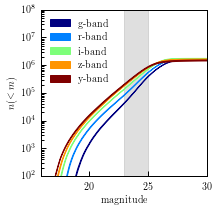

In [185]:
#plot power law fits
colors = pl.cm.jet(np.linspace(0,1,5))  
fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

plt.fill_between([23,25],[0.1,0.1],[10**9,10**9],color='grey', alpha=0.25)

#data
p1 = plt.fill_between(m_bins, n_sample_g-g_err, n_sample_g+g_err, color=colors[0])
p2 = plt.fill_between(m_bins, n_sample_r-r_err, n_sample_r+r_err, color=colors[1])
p3 = plt.fill_between(m_bins, n_sample_i-i_err, n_sample_i+i_err, color=colors[2])
p4 = plt.fill_between(m_bins, n_sample_z-z_err, n_sample_z+z_err, color=colors[3])
p5 = plt.fill_between(m_bins, n_sample_y-y_err, n_sample_y+y_err, color=colors[4])

plt.yscale('log')
plt.xlim([16,30])
plt.ylim([10**2,10**8])
plt.xlabel('magnitude')
plt.ylabel(r'$n(<m)$')
plt.legend([p1, p2, p3, p4, p5],['g-band','r-band','i-band','z-band','y-band'], frameon=False,
           fontsize=10, numpoints=1, loc='upper left')
plt.show()

In [186]:
#calulate errors on the extrapolations
#m_sample = np.arange(12,30,0.1)

ne_samples_g = 1.0*np.zeros((Nj,len(m_sample)))
ne_samples_r = 1.0*np.zeros((Nj,len(m_sample)))
ne_samples_i = 1.0*np.zeros((Nj,len(m_sample)))
ne_samples_z = 1.0*np.zeros((Nj,len(m_sample)))
ne_samples_y = 1.0*np.zeros((Nj,len(m_sample)))

for i in range(0,Nj):
    ne_samples_g[i,:] = power_law(m_sample, *popt_gs[i])
    ne_samples_r[i,:] = power_law(m_sample, *popt_rs[i])
    ne_samples_i[i,:] = power_law(m_sample, *popt_is[i])
    ne_samples_z[i,:] = power_law(m_sample, *popt_zs[i])
    ne_samples_y[i,:] = power_law(m_sample, *popt_ys[i])

g_cov_e = np.matrix(np.cov(ne_samples_g.T, bias=True))*(16-1.0)
g_err_e = np.sqrt(np.diagonal(g_cov_e))

r_cov_e = np.matrix(np.cov(ne_samples_r.T, bias=True))*(16-1.0)
r_err_e = np.sqrt(np.diagonal(r_cov_e))

i_cov_e = np.matrix(np.cov(ne_samples_i.T, bias=True))*(16-1.0)
i_err_e = np.sqrt(np.diagonal(i_cov_e))

z_cov_e = np.matrix(np.cov(ne_samples_y.T, bias=True))*(16-1.0)
z_err_e = np.sqrt(np.diagonal(z_cov_e))

y_cov_e = np.matrix(np.cov(ne_samples_z.T, bias=True))*(16-1.0)
y_err_e = np.sqrt(np.diagonal(y_cov_e))

In [187]:
#make master that uses extrap above mag=25
mask = (m_sample<25)

n_master_sample_g = np.mean(ne_samples_g, axis=0)
n_master_sample_g[mask] = n_sample_g[mask]
g_master_err = g_err_e
g_master_err[mask] = g_err[mask]

n_master_sample_r = np.mean(ne_samples_r, axis=0)
n_master_sample_r[mask] = n_sample_r[mask]
r_master_err = r_err_e
r_master_err[mask] = r_err[mask]

n_master_sample_i = np.mean(ne_samples_i, axis=0)
n_master_sample_i[mask] = n_sample_i[mask]
i_master_err = i_err_e
i_master_err[mask] = i_err[mask]

n_master_sample_z = np.mean(ne_samples_z, axis=0)
n_master_sample_z[mask] = n_sample_z[mask]
z_master_err = z_err_e
z_master_err[mask] = z_err[mask]

n_master_sample_y = np.mean(ne_samples_y, axis=0)
n_master_sample_y[mask] = n_sample_y[mask]
y_master_err = y_err_e
y_master_err[mask] = y_err[mask]

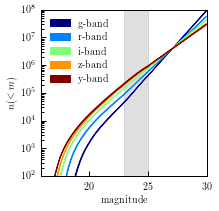

In [188]:
colors = pl.cm.jet(np.linspace(0,1,5))  
fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

plt.fill_between([23,25],[0.1,0.1],[10**9,10**9],color='grey', alpha=0.25)

#data
p1 = plt.fill_between(m_sample, n_master_sample_g-g_master_err, n_master_sample_g+g_master_err, color=colors[0])
p2 = plt.fill_between(m_sample, n_master_sample_r-r_master_err, n_master_sample_r+r_master_err, color=colors[1])
p3 = plt.fill_between(m_sample, n_master_sample_i-i_master_err, n_master_sample_i+i_master_err, color=colors[2])
p4 = plt.fill_between(m_sample, n_master_sample_z-z_master_err, n_master_sample_z+z_master_err, color=colors[3])
p5 = plt.fill_between(m_sample, n_master_sample_y-y_master_err, n_master_sample_y+y_master_err, color=colors[4])

plt.yscale('log')
plt.xlim([16,30])
plt.ylim([10**2,10**8])
plt.xlabel('magnitude')
plt.ylabel(r'$n(<m)$')
plt.legend([p1, p2, p3, p4, p5],['g-band','r-band','i-band','z-band','y-band'], frameon=False,
           fontsize=10, numpoints=1, loc='upper left')
plt.show()

In [191]:
for i in range(0,len(m_sample)):
    print(m_sample[i], n_master_sample_g[i], g_master_err[i])

12.0 0.209705401607 0.0099515569946
12.1 0.209705401607 0.0099515569946
12.2 0.209705401607 0.0099515569946
12.3 0.209705401607 0.0099515569946
12.4 0.209705401607 0.0099515569946
12.5 0.209705401607 0.0099515569946
12.6 0.209705401607 0.0099515569946
12.7 0.209705401607 0.0099515569946
12.8 0.209705401607 0.0099515569946
12.9 0.209705401607 0.0099515569946
13.0 0.209705401607 0.0099515569946
13.1 0.209705401607 0.0099515569946
13.2 0.209705401607 0.0099515569946
13.3 0.209705401607 0.0099515569946
13.4 0.209705401607 0.0099515569946
13.5 0.209705401607 0.0099515569946
13.6 0.209705401607 0.0099515569946
13.7 0.209705401607 0.0099515569946
13.8 0.209705401607 0.0099515569946
13.9 0.209705401607 0.0099515569946
14.0 0.209705401607 0.0099515569946
14.1 0.209705401607 0.0099515569946
14.2 0.209705401607 0.0099515569946
14.3 0.209705401607 0.0099515569946
14.4 0.209705401607 0.0099515569946
14.5 0.209705401607 0.0099515569946
14.6 0.209705401607 0.0099515569946
14.7 0.209705401607 0.009951

In [195]:
from astropy.table import Table

#g
x = m_sample
y = n_master_sample_g
z = g_master_err
names = ['mag','n(<mag)','err']
dat = Table([x,y,z], names=names)
dat.write('./hsc_g_n.dat', format='ascii', overwrite=True)

#r
x = m_sample
y = n_master_sample_r
z = r_master_err
names = ['mag','n(<mag)','err']
dat = Table([x,y,z], names=names)
dat.write('./hsc_r_n.dat', format='ascii', overwrite=True)

#i
x = m_sample
y = n_master_sample_i
z = i_master_err
names = ['mag','n(<mag)','err']
dat = Table([x,y,z], names=names)
dat.write('./hsc_i_n.dat', format='ascii', overwrite=True)

#z
x = m_sample
y = n_master_sample_z
z = z_master_err
names = ['mag','n(<mag)','err']
dat = Table([x,y,z], names=names)
dat.write('./hsc_z_n.dat', format='ascii', overwrite=True)

#y
x = m_sample
y = n_master_sample_y
z = y_master_err
names = ['mag','n(<mag)','err']
dat = Table([x,y,z], names=names)
dat.write('./hsc_y_n.dat', format='ascii', overwrite=True)

In [196]:
print(dat)

mag     n(<mag)           err      
---- -------------- ---------------
12.0 0.209705401607 0.0099515569946
12.1 0.209705401607 0.0099515569946
12.2 0.209705401607 0.0099515569946
12.3 0.209705401607 0.0099515569946
12.4 0.209705401607 0.0099515569946
12.5 0.209705401607 0.0099515569946
12.6 0.209705401607 0.0099515569946
12.7 0.209705401607 0.0099515569946
12.8 0.209705401607 0.0099515569946
12.9 0.209705401607 0.0099515569946
 ...            ...             ...
28.9  14405863.3367   315292.489794
29.0  15448831.6038   345134.678299
29.1  16567309.9527   377741.264717
29.2  17766765.2799   413360.960612
29.3  19053060.2841   452264.347248
29.4  20432482.1235   494745.764631
29.5  21911773.1457   541125.361315
29.6  23498163.8443   591751.318496
29.7  25199408.2005   647002.263076
29.8  27023821.5838   707289.885541
29.9  28980321.3966   773061.779882
Length = 180 rows
